
# True positive proportions in fMRI clusters using Notip

This script showcases the so-called Notip procedure [1], in
which the proportion of true discoveries in arbitrary clusters is estimated.
The clusters can be defined from the input image, i.e. in a circular way, as
the error control accounts for arbitrary cluster selection.


In [ ]:
pip install notip -q

## Fetch dataset
We download a list of left vs right button press maps from the so-called localizer dataset [2]. Concretely, these maps represent the difference in brain activation when subjects are instructed (via auditory cue) to press a button using their left vs their right hand. Note that we fetch individual t-maps that represent the BOLD activity estimate divided by the uncertainty about this estimate.

In [1]:
from nilearn.datasets import fetch_localizer_contrasts
import numpy as np

n_subjects = 30
data = fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects,
    get_tmaps=True,
    legacy_format=False,
)

In [2]:
data_left = fetch_localizer_contrasts(
    ["left button press"],
    n_subjects,
    get_tmaps=True,
    legacy_format=False,
)

data_right = fetch_localizer_contrasts(
    ["right button press"],
    n_subjects,
    get_tmaps=True,
    legacy_format=False,
)

data_2samp = data_left["tmaps"] + data_right["tmaps"]
y = np.array([0] * n_subjects + [1] * n_subjects)

Let's visualize the input data:

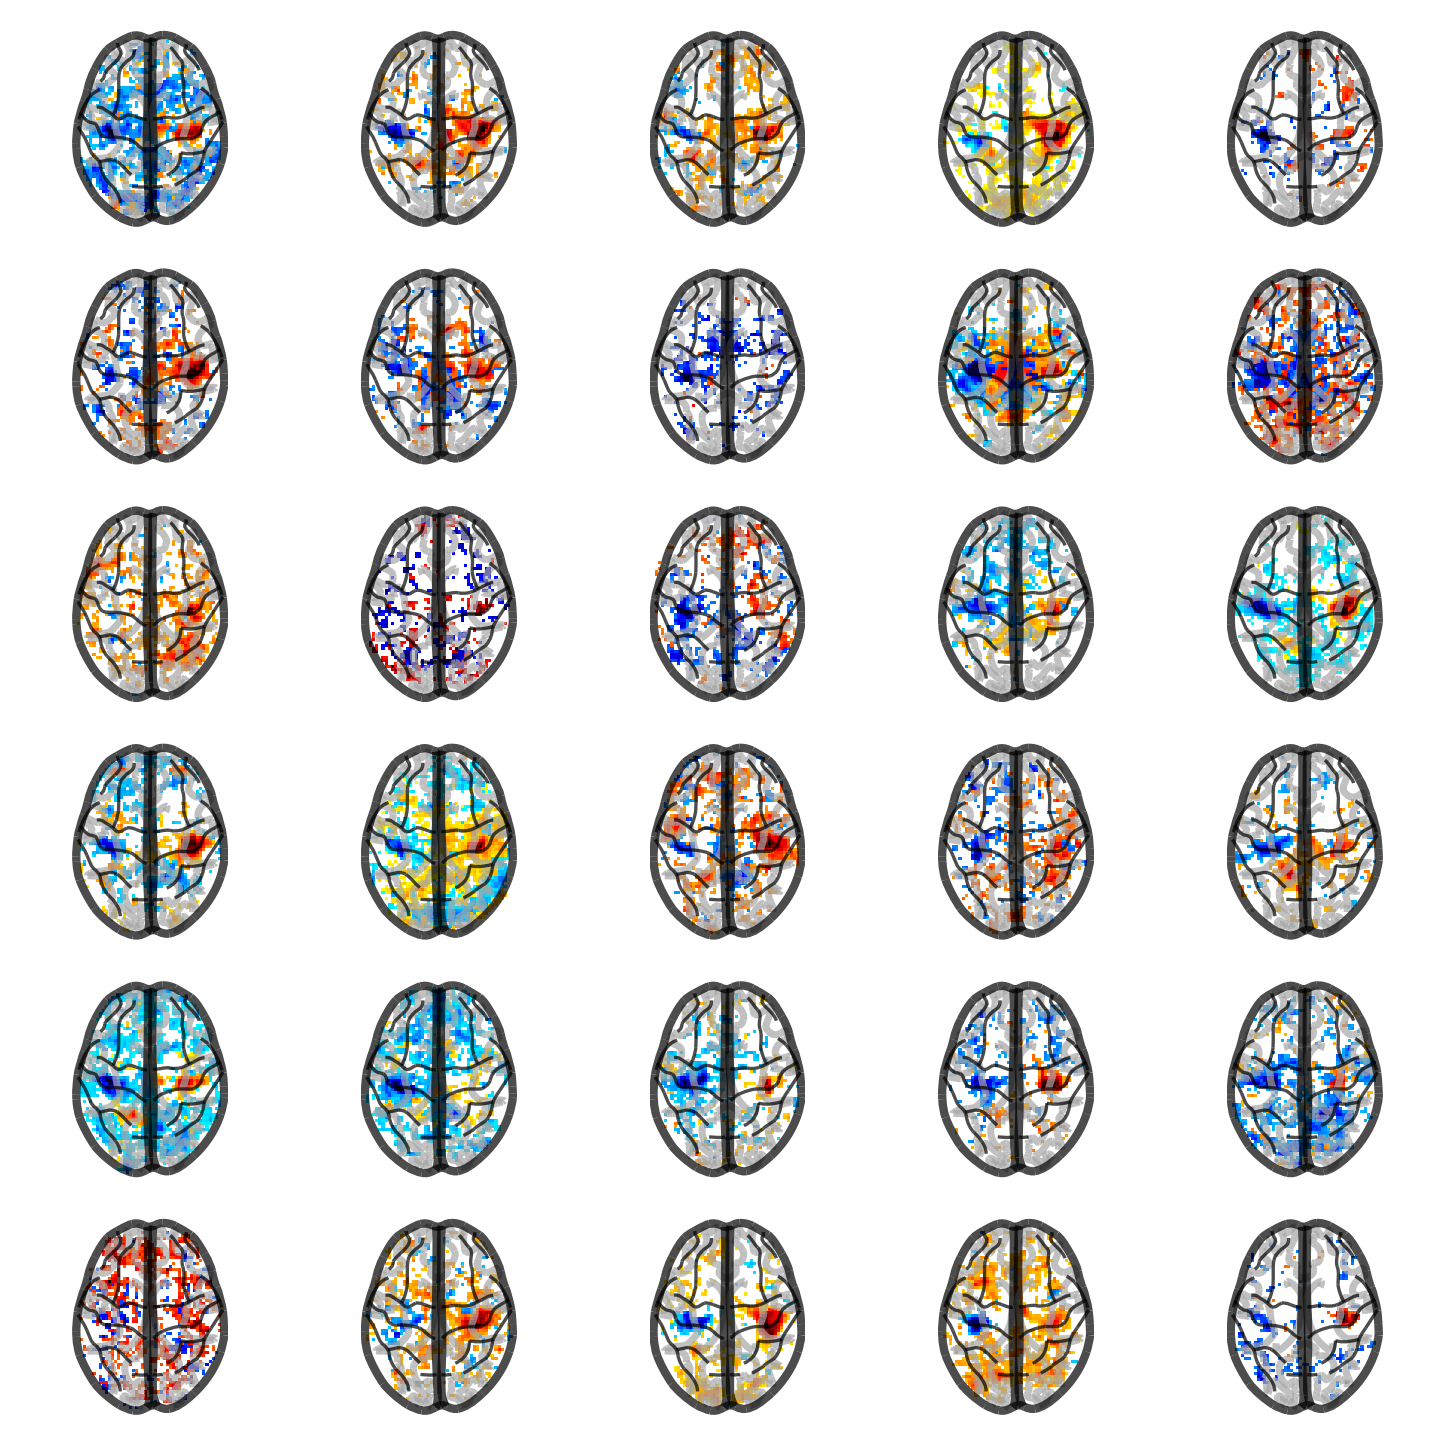

In [6]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(6, 6), dpi=300)
# we use a glass brain to see each map in one glance
for cidx, tmap in enumerate(data['tmaps']):
    plot_glass_brain(
        tmap,
        colorbar=False,
        threshold=2.0,
        axes=axes[int(cidx / 5), int(cidx % 5)],
        plot_abs=False,
        annotate=False,
        display_mode='z')

To extract signal from these images, we need a masker. Whenloading the data, we smooth them with an 8mm-kernel to improve sensitivity. 

In [3]:
from nilearn.maskers import NiftiMasker
smoothing_fwhm = 8.0
nifti_masker = NiftiMasker(smoothing_fwhm=smoothing_fwhm)

In [4]:
fmri_input = nifti_masker.fit_transform(data["tmaps"])

In [5]:
print(fmri_input.shape)

(30, 75019)


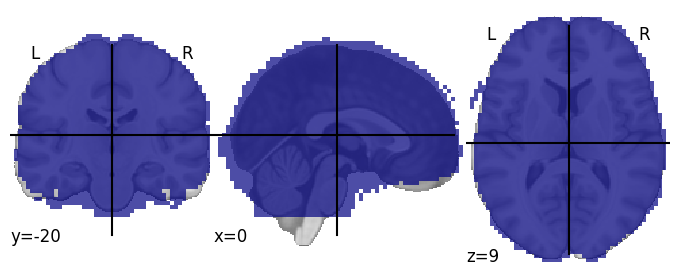

In [6]:
# Note that the masker has automatically computed a brain mask
# One can take a look at it
from nilearn.plotting import plot_roi
plot_roi(nifti_masker.mask_img_)

We have extracted the values of 75019 voxels from 30 images.

### Computing True Discovery Proportion (TDP) lower bounds on data-derived clusters

First, we need to compute a statistical map from the input data. This is done via a t-test, performed for each voxel.

In [7]:
from scipy import stats
from scipy.stats import norm

# Let's run a one-sample t test on these data
stats_, p_values = stats.ttest_1samp(
    fmri_input, 0, alternative='greater')

# Let's make this an image by using the inverse_transform method of the masker
stat_map = nifti_masker.inverse_transform(stats_)

p_values_map = nifti_masker.inverse_transform(p_values)

Let us visualise the resulting t map:

/home/ablain/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



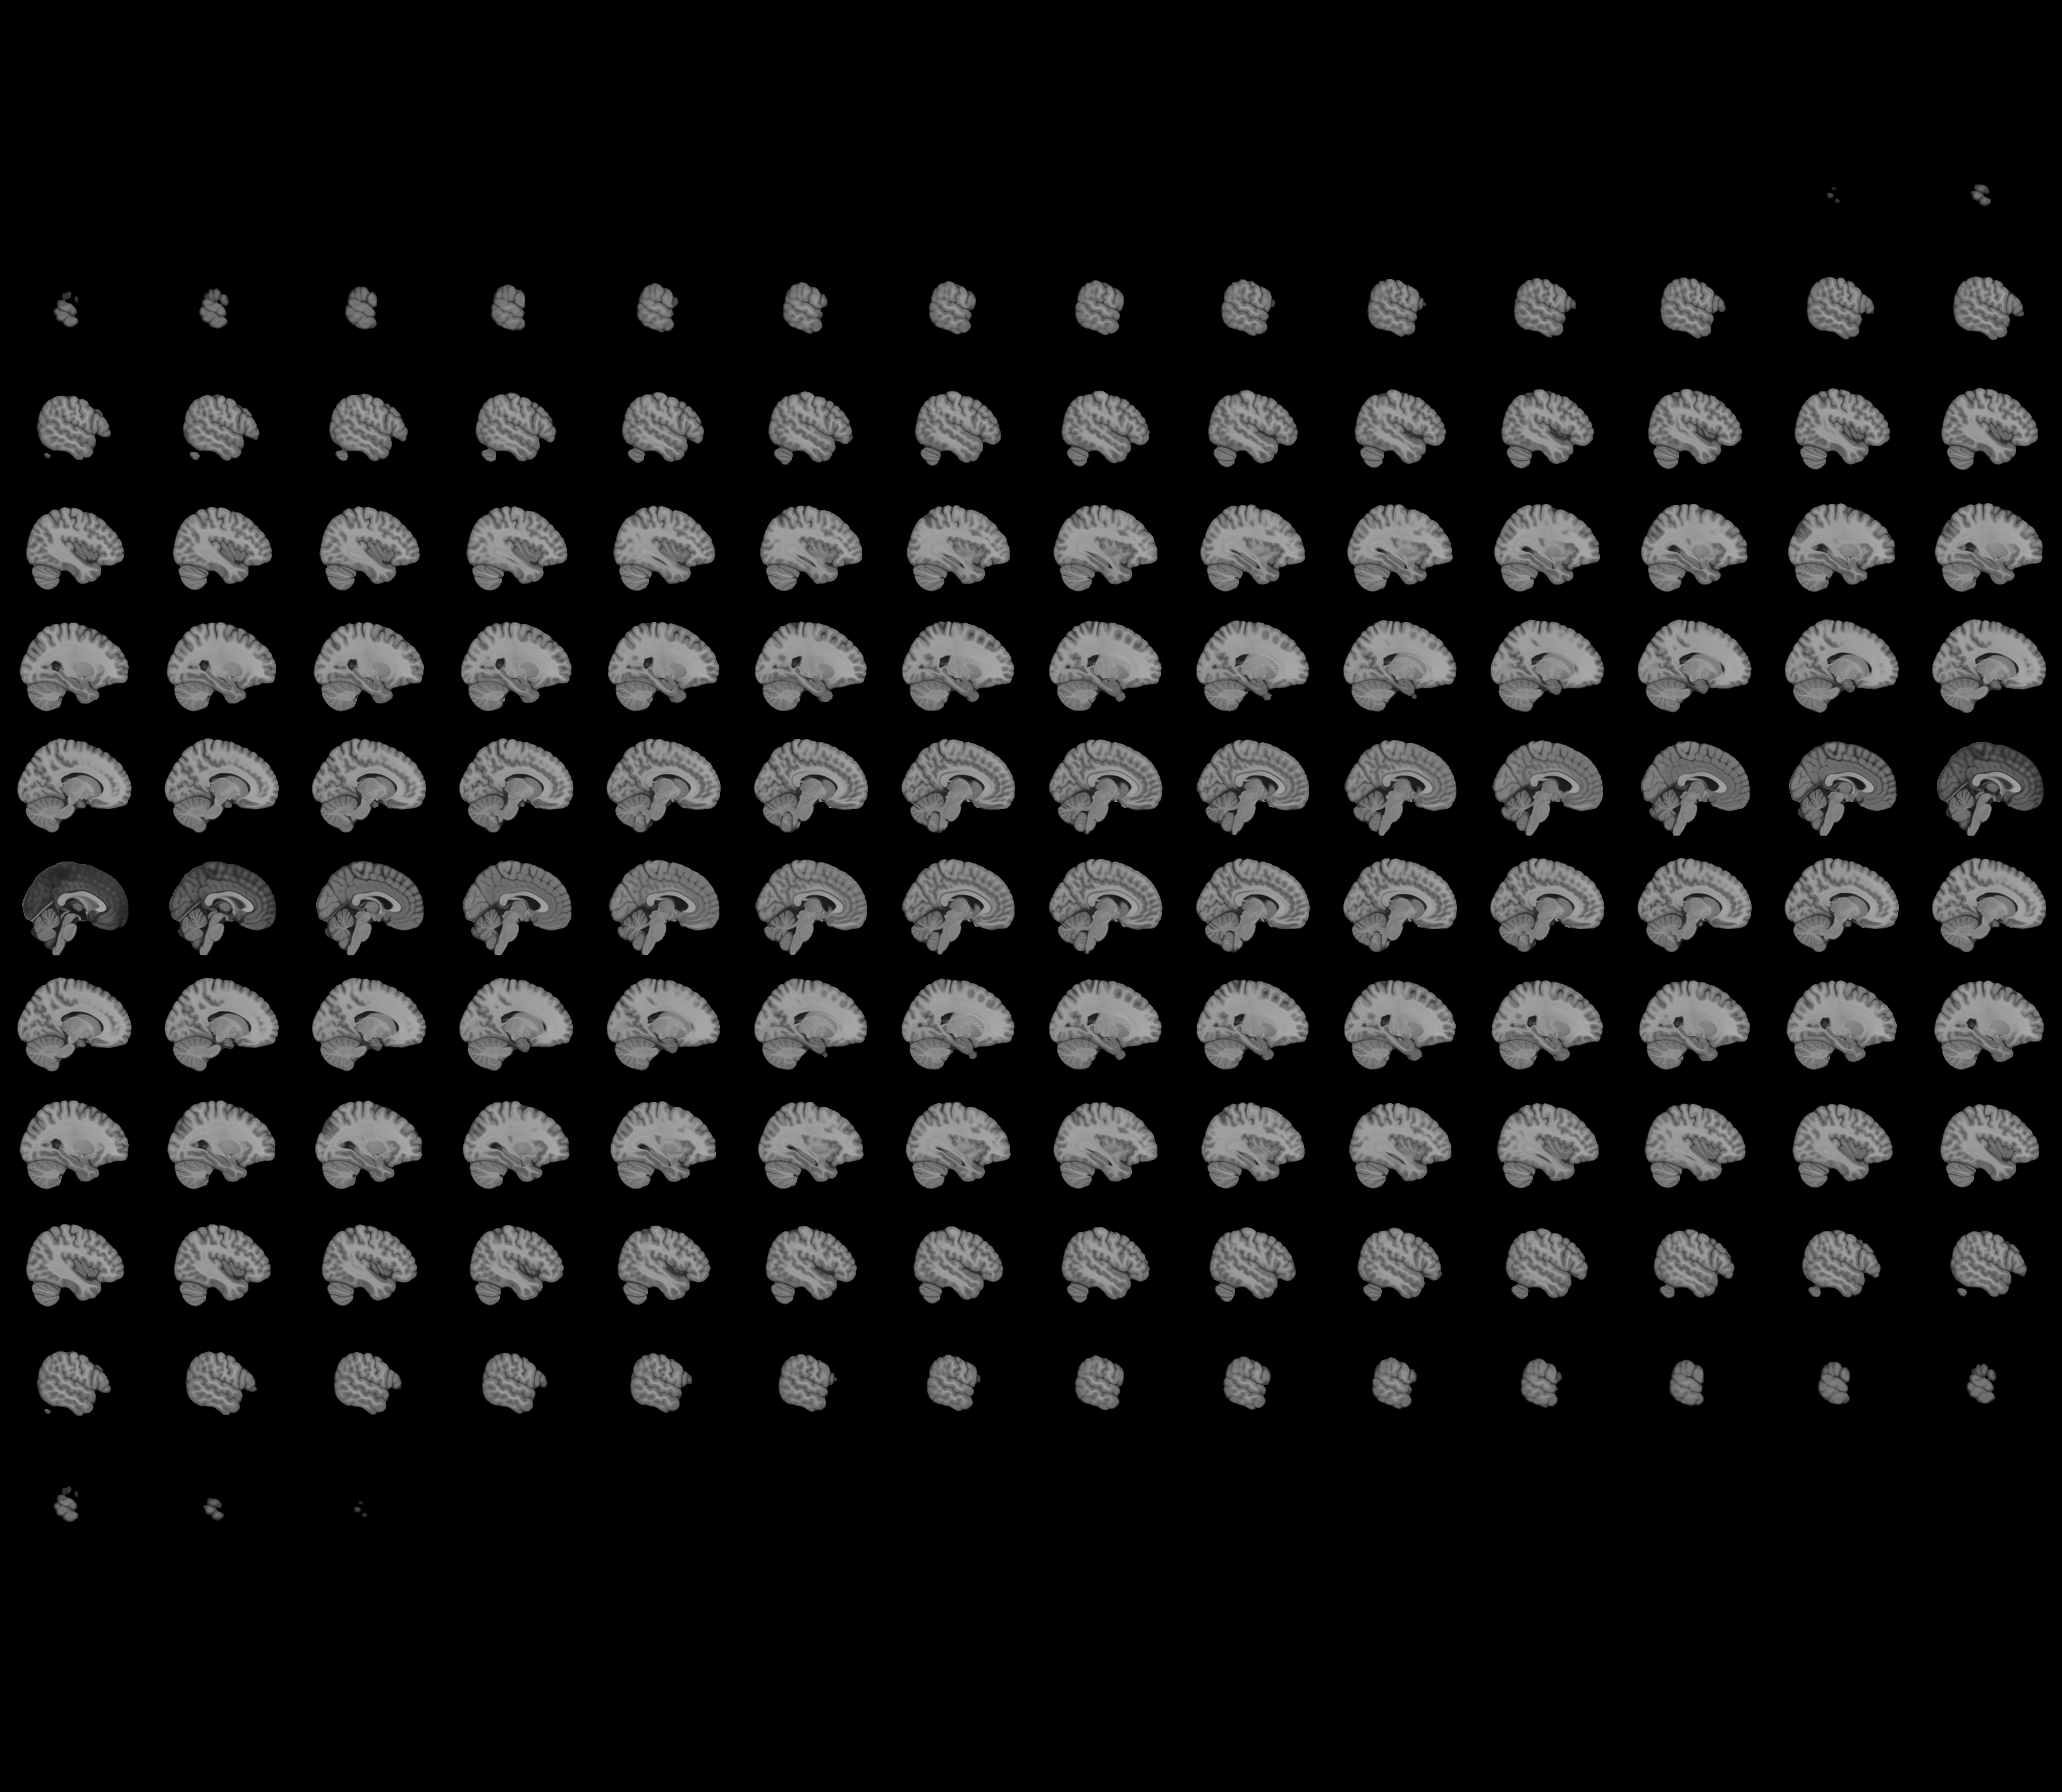
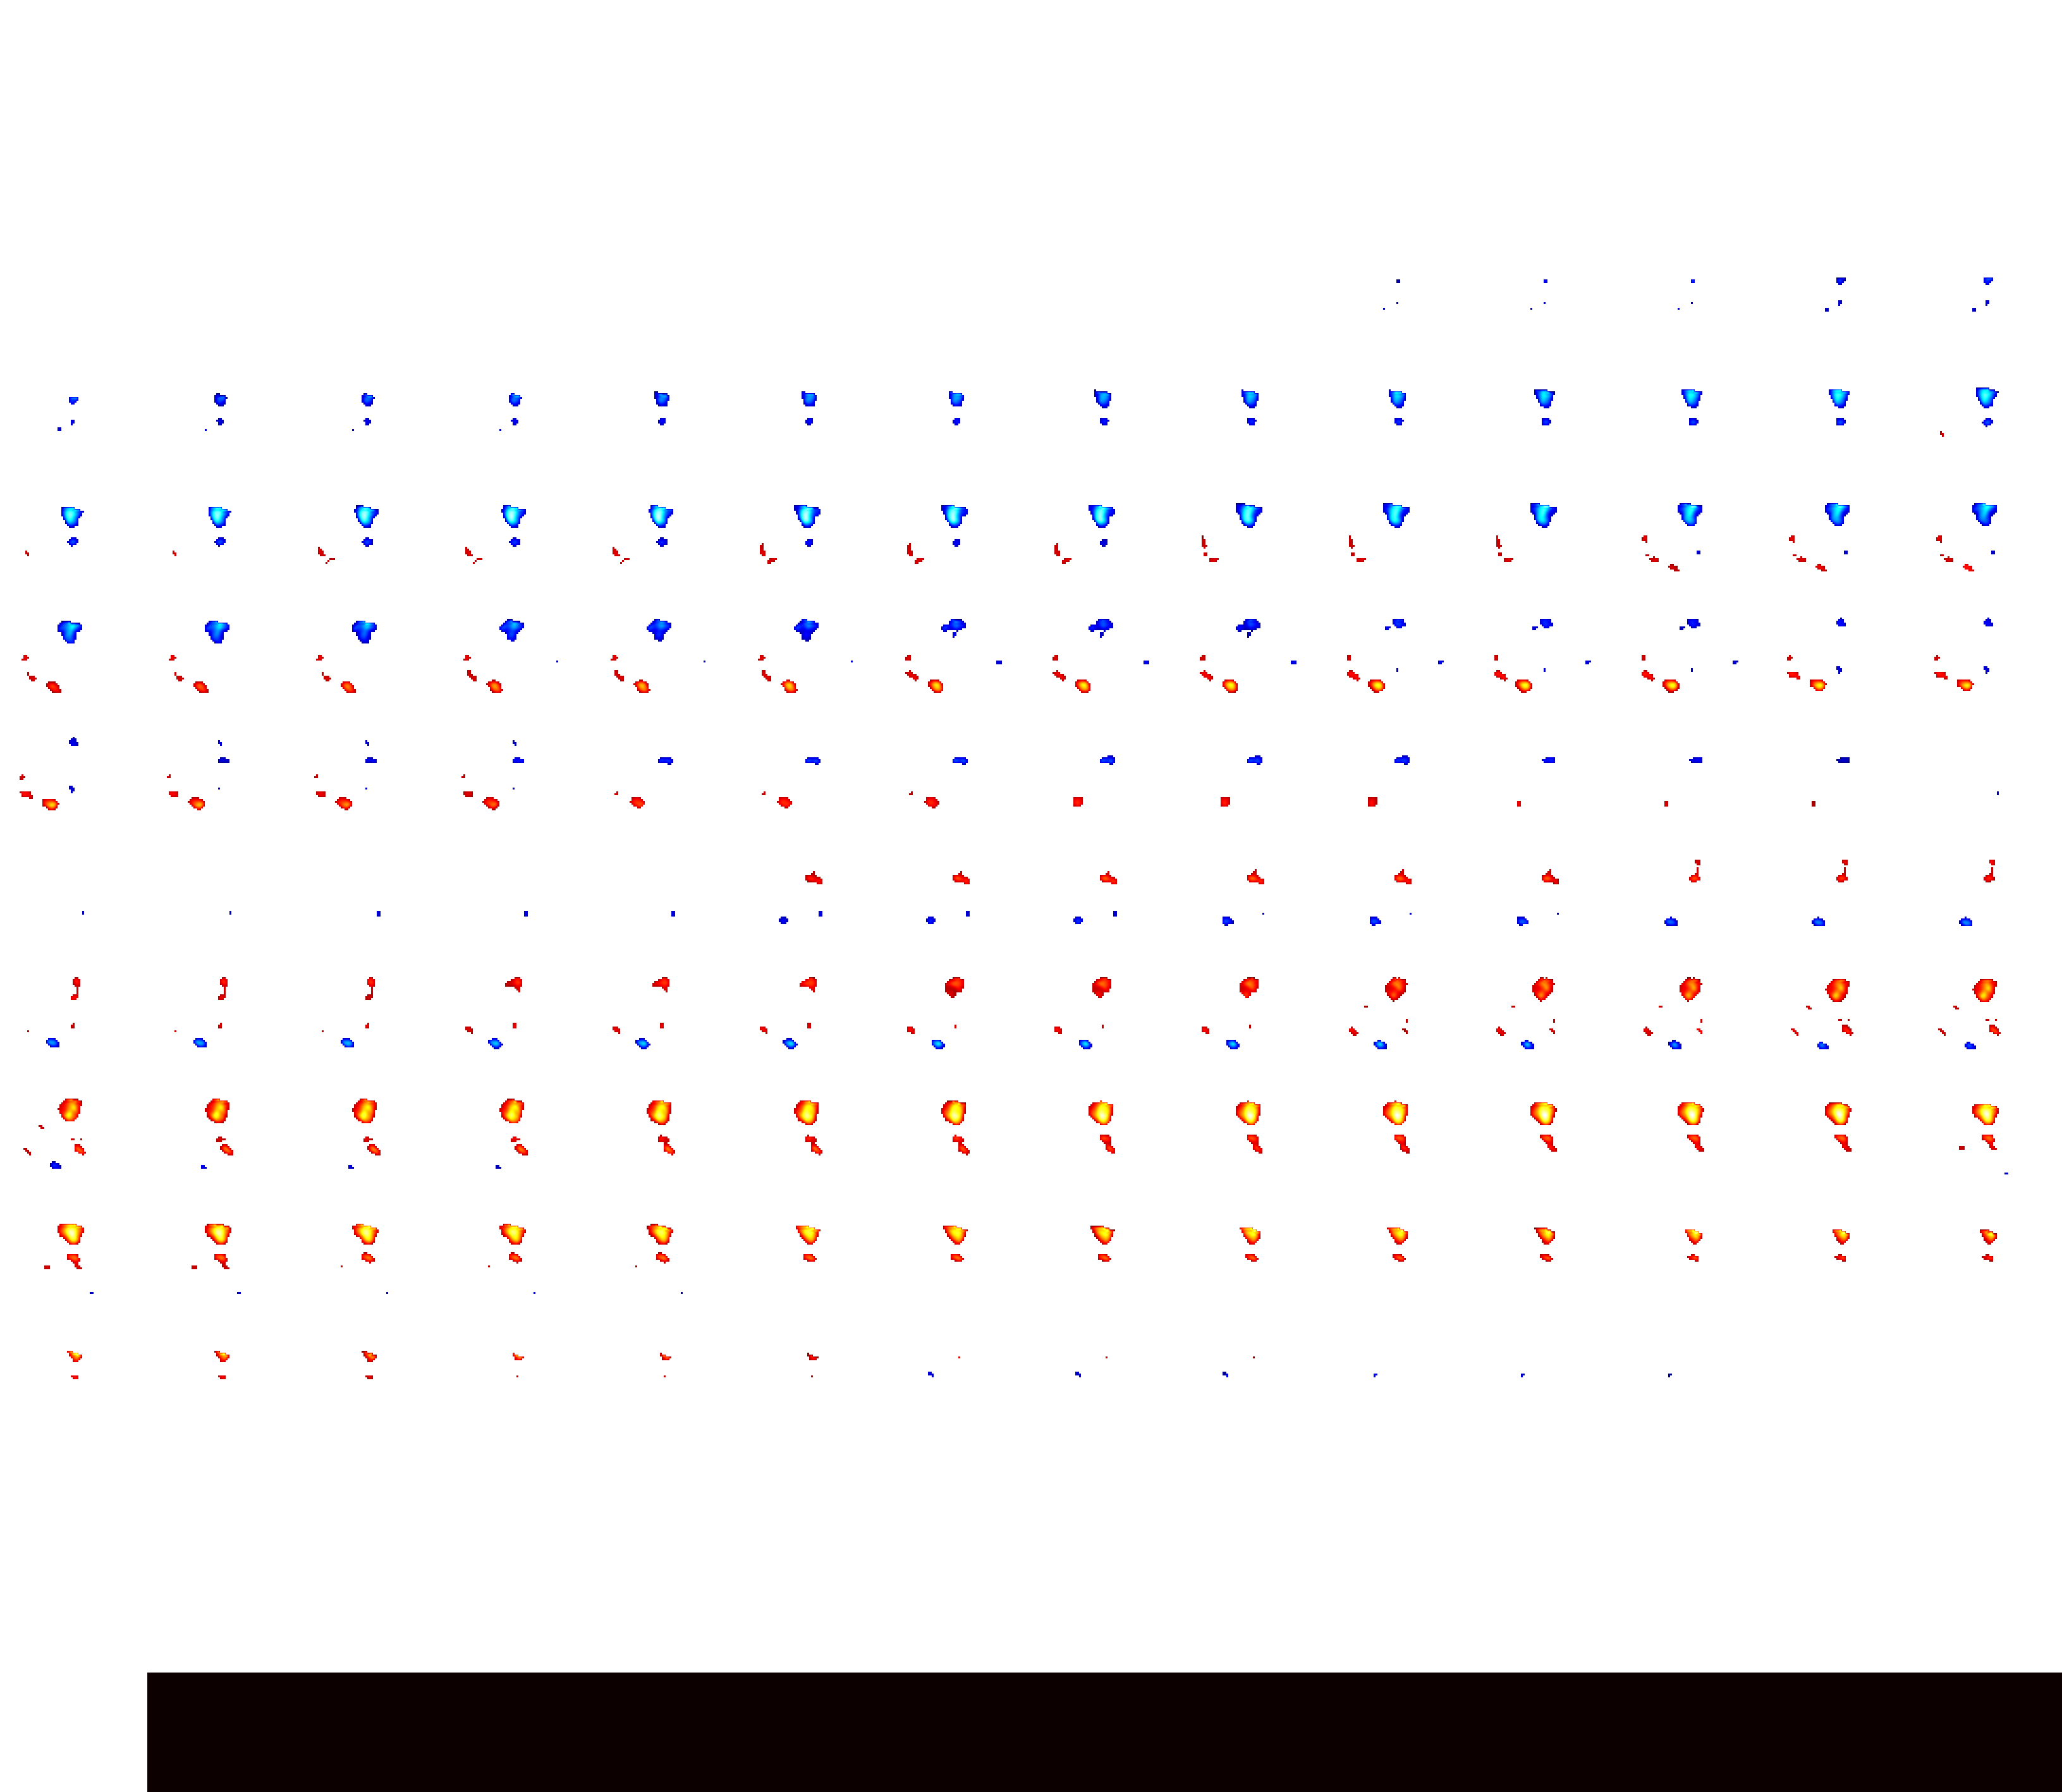

In [8]:
from nilearn.plotting import view_img
stat_threshold = 3.5
view_img(stat_map, 
         title='Group-level t-map',
         threshold=stat_threshold,
         colorbar=True)

This map makes sense.
We can now use Notip to compute TDP lower bounds on clusters exceeding a z-value threshold. We set this threshold to 3.5.

In [9]:
from notip.posthoc_fmri import get_clusters_table_TDP_1samp
get_clusters_table_TDP_1samp(
    fmri_input,
    n_permutations=200,
    stat_threshold=stat_threshold,
    methods=['Notip'],
    nifti_masker=nifti_masker)

/home/ablain/.local/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Cluster ID     X     Y     Z Peak Stat Cluster Size (mm3) TDP (Notip)
0           1  39.0 -21.0  54.0     13.07              39231        0.95
1          1a   9.0 -18.0  51.0      6.42                               
2          1b   6.0  -3.0  45.0      5.23                               
3           2 -18.0 -51.0 -24.0      9.96               8910        0.80
4           3  30.0  -9.0   0.0      6.93               8694        0.78
5          3a  45.0 -18.0  18.0      6.75                               
6           4 -15.0 -96.0  -6.0      5.10               6345        0.66
7          4a -18.0 -87.0  -9.0      4.96                               
8          4b -27.0 -96.0  21.0      4.42                               
9          4c -39.0 -93.0  -3.0      4.22                               
10          5  21.0 -93.0   0.0      4.97               1242        0.22
11          6  18.0 -21.0   6.0      4.28                351        0.00
12          7  27.0 -69.0  36.0      3.83                162        0.00
13          8  42.0 -60.0   3.0      3.82                189        0.00
14          9  27.0  -6.0  15.0      3.57                 81        0.00

The same thing can be done in the two-sample setting:

In [11]:
from notip.posthoc_fmri import get_clusters_table_TDP_2samp
input_2samp = nifti_masker.transform(data_2samp)
get_clusters_table_TDP_2samp(
    input_2samp, y,
    n_permutations=200,
    stat_threshold=stat_threshold,
    methods=['Notip'],
    nifti_masker=nifti_masker)

20


Cluster ID     X     Y     Z Peak Stat Cluster Size (mm3) TDP (Notip)
0          1 -39.0 -24.0  63.0      7.56              12582        0.74
1         1a -36.0 -21.0  51.0      7.28                               
2          2  18.0 -48.0 -24.0      4.18                405        0.00

We have reduced the number of permutations to 200 for the sake of computation time. Note that we can get tighter FDP control by increasing this number.

### Comparison with other TDP lower bounds 

There exist other approach to get TDP estimates. Among those, All-Resolution-Inference (ARI) does not require permutations. Let us compare their result.

In [ ]:
from notip.posthoc_fmri import get_clusters_table_TDP_1samp
get_clusters_table_TDP_1samp(
    fmri_input, 
    n_permutations=200,
    stat_threshold=stat_threshold,
    methods=['ARI', 'Notip'],
    nifti_masker=nifti_masker)

### Using Notip on regions from atlases

In [ ]:
from nilearn import datasets
# atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')

atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr0-2mm")
atlas_masker = NiftiMasker(smoothing_fwhm=None)

atlas_filename = atlas.maps
labels = atlas.labels
atlas_masked = atlas_masker.fit_transform(atlas_filename)

# project the data onto the same space

fmri_input_atlas = atlas_masker.transform(data["tmaps"])

We have 48 atlas regions.

In [ ]:
labels

In [ ]:
import numpy as np
from nilearn.image import math_img

# Find the index of the Precentral Gyrus
idx = np.where(np.array(labels) == 'Precentral Gyrus')[0]

# make it a binary region definition
region_mask =  math_img(f'i1 == {idx}', i1=atlas_filename)
plot_roi(region_mask)

In [ ]:
from notip.posthoc_fmri import tdp_bound_notip_1samp
notip_bound, cluster_map = tdp_bound_notip_1samp(
    fmri_input_atlas,
    region_mask,
    n_permutations=200,
    nifti_masker=atlas_masker)

In [ ]:
from nilearn.plotting import plot_stat_map
plot_stat_map(cluster_map, title='TDP > {0:.2f}'.format(notip_bound))

### Using Notip on user-defined clusters

We will now use Notip on clusters extracted from the data; we seek to find connected components exceeding a z-value threshold.

In [ ]:
from nilearn.regions import connected_regions
from nilearn.image import binarize_img, index_img

# binarize the thresholded stat map
th_img = binarize_img(stat_map, 3.5)

# Extract the connected components
label_map, indices = connected_regions(
    th_img,
    min_region_size=1350,
    extract_type='connected_components',
    mask_img=None)

# Get the spatial map corresponding to the first cluster
# i.e. with index = 0
cluster_mask = index_img(label_map, 0)

# look at it
plot_roi(cluster_mask)

In [ ]:
np.count_nonzero(cluster_mask.get_fdata())

This cluster comprises 1453 voxels.
Now, let's infer the TDP on this region. This looks circular ---it is actually--- as the region was defined from the map in the first place, but in the present case, this is legal, as we use a post-hoc inference scheme.

In [ ]:
from notip.posthoc_fmri import tdp_bound_notip_1samp
notip_bound, cluster_map = tdp_bound_notip_1samp(
    fmri_input,
    cluster_mask,
    n_permutations=200,
    nifti_masker=nifti_masker)

Let's visualize the results:

In [ ]:
plot_stat_map(
    cluster_map, title='TDP > {0:.2f}'.format(notip_bound))

## FDP control vs FDR control

We can also apply Notip to obtain a TDP lower bound on the 5% Benjamini-Hochberg region:

In [ ]:
from nilearn.glm import fdr_threshold
from scipy.stats import norm
from nilearn.image import threshold_img, math_img
q = 0.05

z_values = norm.isf(p_values)
bh_region = z_values >= fdr_threshold(z_values, q)

stat_threshold_bh = np.min(stats_[bh_region])
print('BH threshold: {0:.2f}'.format(stat_threshold_bh))

plot_stat_map(
    stat_map, 
    threshold=stat_threshold_bh, 
    title='TDR > {0:.2f}'.format(1 - q))

In [ ]:
# To infer on the TDP in this region, we binarize the stat map
bh_mask = binarize_img(stat_map, stat_threshold_bh)

# Then we call the TDP inference function on this particular region
notip_bound, cluster_map = tdp_bound_notip_1samp(
    fmri_input,
    bh_mask,
    n_permutations=200,
    nifti_masker=nifti_masker)

In [ ]:
plot_stat_map(cluster_map, title='TDP > {0:.2f}'.format(notip_bound))

Note that Notip only guarantees that, with high probability, about half of voxels at least are active in this region: FDR control does not imply FDP control at the same level. We can relax the required TDP guarantee by using $\alpha = 0.1$ instead of the default $\alpha = 0.05$.

In [ ]:
# To infer on the TDP in this region, we binarize the stat map
bh_mask = binarize_img(stat_map, stat_threshold_bh)

# Then we call the TDP inference function on this particular region
notip_bound, cluster_map = tdp_bound_notip_1samp(
    fmri_input,
    bh_mask,
    alpha=0.1,
    n_permutations=200,
    nifti_masker=nifti_masker)

In [ ]:
plot_stat_map(cluster_map, title='TDP > {0:.2f} with probability > 90%'.format(notip_bound))

# References

Blain, Alexandre, Bertrand Thirion, and Pierre Neuvial. "Notip: Non-parametric True Discovery Proportion control for brain imaging." NeuroImage 260 (2022): 119492. doi:https://doi.org/10.1016/j.neuroimage.2022.119492

Dimitri Papadopoulos Orfanos, Vincent Michel, Yannick Schwartz, Philippe Pinel, Antonio Moreno, Denis Le Bihan, and Vincent Frouin. The brainomics/localizer database. NeuroImage, 144:309–314, 2017. Data Sharing Part II. URL: https://www.sciencedirect.com/science/article/pii/S1053811915008745, doi:https://doi.org/10.1016/j.neuroimage.2015.09.052.